In [2]:
from fastai2.vision.all import *
from utils import *

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
path.ls().sorted()

(#50) [Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01.obj'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/02'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/02.obj'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/03'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/03.obj'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/04'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/04.obj'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/05'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/05.obj')...]

In [5]:
(path/'01').ls().sorted()

(#1000) [Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/depth.cal'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('/home/jayajasodani/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [6]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/home/jayajasodani/.fastai/data/biwi_head_pose/21/frame_00375_pose.txt')

In [7]:
im= PILImage.create(img_files[0])
im.shape

(480, 640)

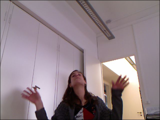

In [8]:
im.to_thumb(160)

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6) #generates array from string. Skips last 6 lines
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1=ctr[0]*cal[0][0]/ctr[2] + cal[0][2]
    c2=ctr[1]*cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [10]:
get_ctr(img_files[0]) #gets the center of head COORDINATES from pose coordinates

tensor([324.1116, 301.1465])

In [11]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6) # caliberation 3X3 array
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [12]:
ctr = np.genfromtxt(img2pose(img_files[0]), skip_header=3) #center point of head from pose
ctr

array([   9.71419,  143.286  , 1223.09   ])

In [13]:
cal[0][0]

517.679

In [14]:
c1=ctr[0]*cal[0][0]/ctr[2] + cal[0][2]
c1                     #all centers x coordinates lie around 324.11 and y coordinates around 301.1

324.11157982242514

In [15]:
biwi = DataBlock(
        blocks = (ImageBlock, PointBlock),
        get_items=get_image_files,
        get_y=get_ctr,
        splitter=FuncSplitter(lambda o: o.parent.name=='13'), #why13?
        batch_tfms=[*aug_transforms(size=(240,320)),
                   Normalize.from_stats(*imagenet_stats)]
)

In [16]:
#??FuncSplitter
path.parent.name

'data'

In [17]:
Normalize.from_stats(*imagenet_stats)

Normalize: (TensorImage,object) -> encodes (TensorImage,object) -> decodes

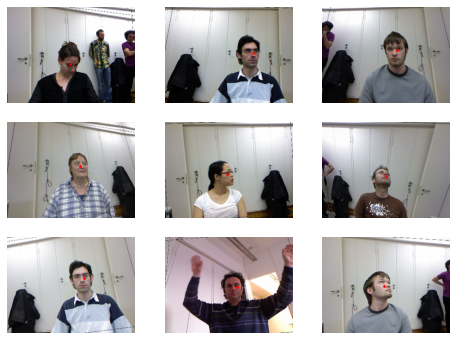

In [18]:
dls=biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [19]:
xb,yb=dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [20]:
yb[0]

tensor([[0.1013, 0.4455]])

In [21]:
learn = cnn_learner(dls, resnet18, y_range=(1,-1))

In [22]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

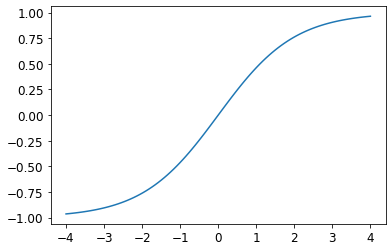

In [23]:
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

In [24]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.03981071710586548)

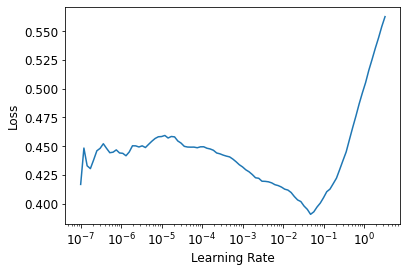

In [25]:
learn.lr_find()

In [26]:
lr=2e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.050445,0.002487,40:04


epoch,train_loss,valid_loss,time
0,0.005691,0.001909,56:58
1,0.001959,0.000164,56:18
2,0.001161,0.000111,56:19


In [ ]:
math.sqrt(0.0001)

In [ ]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))